In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
import spacy
import tqdm

In [3]:
# Create the spaCy pipeline for NER tagging (looking for companies in this case)
nlp = spacy.load("en_core_web_sm")
if nlp.has_pipe('parser'):
    nlp.remove_pipe('parser')
if not nlp.has_pipe('sentencizer'):
    nlp.add_pipe(nlp.create_pipe('sentencizer'), before='ner')
nlp.pipeline

[('tagger', <spacy.pipeline.pipes.Tagger at 0x12d2e35f8>),
 ('sentencizer', <spacy.pipeline.pipes.Sentencizer at 0x12ee0c128>),
 ('ner', <spacy.pipeline.pipes.EntityRecognizer at 0x12edc6528>)]

### Load Raw Data

In [220]:
cnx = sqlite3.connect('/Users/eczech/Downloads/all-the-news.db')
dfr = pd.read_sql_query("SELECT * FROM longform", cnx)
dfr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204135 entries, 0 to 204134
Data columns (total 12 columns):
id             204135 non-null int64
title          204135 non-null object
author         172000 non-null object
date           191532 non-null object
content        191181 non-null object
year           191532 non-null object
month          191532 non-null object
publication    196420 non-null object
category       168713 non-null object
digital        193115 non-null float64
section        74572 non-null object
url            98796 non-null object
dtypes: float64(1), int64(1), object(10)
memory usage: 18.7+ MB


In [221]:
dfr['category'].value_counts()

newspaper       61264
general         52152
broadcast       18672
wire            15055
radio           12001
business         8344
Reports           854
Exclusive         214
Longform          137
Book Reviews       20
Name: category, dtype: int64

In [222]:
dfr.groupby(['category', 'publication']).size()

category      publication        
Book Reviews  Verge                     20
Exclusive     Verge                    214
Longform      Verge                    137
Reports       Verge                    854
broadcast     CNN                    14288
              Fox News                4384
business      Business Insider        8344
general       Atlantic                7386
              Breitbart              23791
              Buzzfeed News          10699
              Talking Points Memo     5323
              Vox                     4953
newspaper     Guardian                9920
              Los Angeles Times       9036
              New York Times         30257
              Washington Post        12051
radio         NPR                    12001
wire          Reuters                15055
dtype: int64

Restrict to Business Insider articles:

In [223]:
df = dfr[dfr['category'] == 'business'].copy()
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8344 entries, 56128 to 64471
Data columns (total 12 columns):
id             8344 non-null int64
title          8344 non-null object
author         5541 non-null object
date           8344 non-null datetime64[ns]
content        8344 non-null object
year           8344 non-null object
month          8344 non-null object
publication    8344 non-null object
category       8344 non-null object
digital        8344 non-null float64
section        0 non-null object
url            0 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(9)
memory usage: 847.4+ KB


In [1152]:
import re
sent_pattern = r'\', \''
def clean(text):
    matches = re.split(sent_pattern, text)
    def clean_token(t):
        t = t.replace('\\n', '')
        t = re.sub(r'^\W+', '', t)
        t = re.sub(r'[^\w.]+$', '', t)
        t = t.replace('\\', '')
        return t.strip()
    matches = [clean_token(t) for t in matches]
    return ' '.join([m for m in matches if len(m) > 10])
print(clean(df['content'].loc[56168])[:100])

2016 saw a dry spell for tech IPOs, but investors are already counting on 2017 to turn the tides. Al


Identify individual sentences expressing something about future layoffs manually:

In [32]:
from spacy.matcher import Matcher
matcher = Matcher(nlp.vocab)
matcher.add("p1", None, [
    {"ENT_TYPE": "ORG"}, {"OP": "*"}, 
    {"LOWER": {"IN": ['fired', 'eliminated', 'terminated']}}, {"OP": "*"},
    # Target plurality for greater precision
    {"LOWER": {"IN": ['employees', 'workers', 'engineers', 'developers', 'personnel', 'workforce']}}
])
matcher.add("p3", None, [{"LEMMA": 'lay'}, {"LEMMA": 'off'}, {"OP": "*"}, {"ENT_TYPE": "ORG"}])
matcher.add("p3", None, [{"LEMMA": 'Lay'}, {"LEMMA": 'off'}, {"OP": "*"}, {"ENT_TYPE": "ORG"}])
matcher.add("p2", None, [{"ENT_TYPE": "ORG"}, {"OP": "*"}, {"LEMMA": 'lay'}, {"LEMMA": 'off'}])
matcher.add("p2", None, [{"ENT_TYPE": "ORG"}, {"OP": "*"}, {"LEMMA": 'Lay'}, {"LEMMA": 'off'}])
matcher.add("p4", None, [{"TEXT": {"REGEX": '^[lL]ayoff[s]?$'}}, {"OP": "*"}, {"ENT_TYPE": "ORG"}])
matcher.add("p5", None, [{"ENT_TYPE": "ORG"}, {"OP": "*"}, {"TEXT": {"REGEX": '^[lL]ayoff[s]?$'}}])

def get_matches(sent):
    matches = matcher(sent)
    res = {}
    for match_id, start, end in matches:
        string_id = nlp.vocab.strings[match_id]
        span = sent[start:end] 
        for ent in span.ents:
            if ent.label_ == 'ORG':
                res[span.text] = ent
    return [(v, k) for k, v in res.items()]

def get_text(r):
    to_str = lambda t: clean(t) + '. ' if not pd.isnull(t) else ''
    text = to_str(r['title']) + to_str(r['content'])
    return text
        
def extract(df):
    res = []
    df = df[df['content'].notnull() | df['title'].notnull()]
    for i, r in tqdm.tqdm_notebook(df.iterrows(), total=len(df)):
        doc = nlp(get_text(r))
        for sent in doc.sents:
            m = get_matches(sent.as_doc())
            for t, span in m:
                rec = {'org': t.text, 'phrase': span, 'sent': sent}
                res.append({**r[['id', 'date', 'year', 'month', 'publication', 'category']].to_dict(), **rec})
    return pd.DataFrame(res)

dfe = extract(df)
dfe['date'] = pd.to_datetime(dfe['date'])

In [35]:
dfe['org'].nunique()

56

Since the pipeline will tag "Organizations", filter some of those down to companies rather than government agencies, sports teams, religious groups, etc.:

In [141]:
rmc = [
    'Donald Trump', 'Trump', 'Russia', 'North Korea', 'FBI', 'Attacks  & Shots', 
    'Reuters', 'Comey', 'Mueller', 'Donald Trump', 'James  Comey', 'Couric', 'Secret Service',
    'White House', 'Energy', 'Jags', 'Cover Up', 'Several Revolutionary Guard',
    'Reusability', 'Attacks  & Shots', 'USS Nitze', 'United Kingdo Entered',
    'Basically', 'Banks', 'Times', 'Musk', 'Sanders', 'Business Insider', 'Business Insider.xa',
    'McFarland',
    # Actual companies, bad hits
    'Starboard', 'Morgan Stanley', 'Reddit', 'Amazon'
]
cts = dfe[~dfe['org'].isin(rmc)].groupby('org')['id'].nunique().sort_values(ascending=False)
cts

org
Yahoo                                       6
IBM                                         2
Apple                                       2
Intel                                       2
Sears                                       2
ESPN                                        2
Microsoft                                   2
GoPro                                       2
Goldman                                     1
IAC                                         1
HotelTonight                                1
HP CEOxa0Dion Weisler                       1
HP                                          1
Google                                      1
the National Bureau of Economic Research    1
GTS                                         1
ISAP                                        1
Ford                                        1
ESL Investments                             1
EMC                                         1
Disney                                      1
Bank of America               

In [142]:
dfef = dfe[~dfe['org'].isin(rmc)]
dfef.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 154 entries, 0 to 201
Data columns (total 9 columns):
category       154 non-null object
date           154 non-null datetime64[ns]
id             154 non-null int64
month          154 non-null int64
org            154 non-null object
phrase         154 non-null object
publication    154 non-null object
sent           154 non-null object
year           154 non-null int64
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 12.0+ KB


### Visualize Timeline of Layoff Events

In [1166]:
pd.set_option('display.max_colwidth', 10000)
dfef.sample(n=15, random_state=1)[['org', 'date', 'publication', 'phrase']]

,org,date,publication,phrase
73,ESPN,2017-04-30,Business Insider,"layoffs do show that ESPN is dealing with the sting of digital disruption, they don’t mean the business is doomed, according to a recent report by analysts at Morgan"
47,Moonbot Studios,2017-04-11,Business Insider,Moonbot Studios went through a round of layoffs
92,Stores,2017-05-15,Business Insider,"xa0Meanwhile, Sears has been burning through cash at a rate of more than $1 billion per yearxa0and selling off real estate and other assets to stay afloat Stores have been laying off"
194,LeEco’s,2016-12-13,Business Insider,"LeEco’s smartphone business] is being solved gradually, and product supply will return to normal soon ... [the company] is moving forward smoothly on related fundraising plans, and we will make an announcement at an appropriate time,” Jia said at a business forum in Beijing Media reports in November said LeEco had defaulted on payments to its suppliers amid a cash crunch which cast doubt on its plan to produce an electric car, a dream that Jia has heavily invested in Jia said the plan was going ahead and LeEco will announce substantial progress on its production plant, in Deqing county in eastern China’s Zhejiang province, by the end of this month The company announced in August a plan to invest 12 billion yuan in an electric car factory capable of making 400,000 cars a year by 2018 LeEco is also in partnership to make electric cars in the US with electric car start-up Faraday Future, which was also said to have halted construction of its Nevada factory We and our strategic partner FF [Faraday Future] will demonstrate the revolutionary achievement we have made soon,” Jia said LeEco has burned through more than 10 billion yuan on its car investment, putting pressure on the company which is having difficulty raising cash Further questions were raised after LeEco’s Shenzhen-listed unit, Leshi Internet Information and Technology Corp, halted trading on December 7 The suspension came after the company’s share fell to as low as 35.01 yuan over mounting concerns that staff would be laid off"
45,Google,2017-04-01,Business Insider,Google was rethinking Titan too It decided to move Titan to Mountain View and laid off
136,IBM,2016-03-03,Business Insider,"layoffs, as IBM looks to shed expenses from its shrinking businesses An IBM official confirms that it is continuing to cut jobs in some departments while offering bountiful help-wanted listings on others A spokesperson sent us this statement IBM"
125,IBM,2016-03-03,Business Insider,"layoff is that IBM has severely cut severance pay to one month total, no matter how many years of service the employee worked, several workers have confirmedxa0to a Facebook page called xa0The page is maintained by Lee Conrad, the man who ran a former IBM"
15,Kmart,2017-01-28,Business Insider,"Kmart, confirmed the layoffs"
67,ESPN,2017-04-30,Business Insider,"layoffs are high-profile and painful for ESPN, and on a surface level, seem to validate ESPN"
58,ESPN,2017-04-30,Business Insider,"layoffs most likely are marginal cuts for the network that pays billions in sports rights every year, but they clearly signal that ESPN"


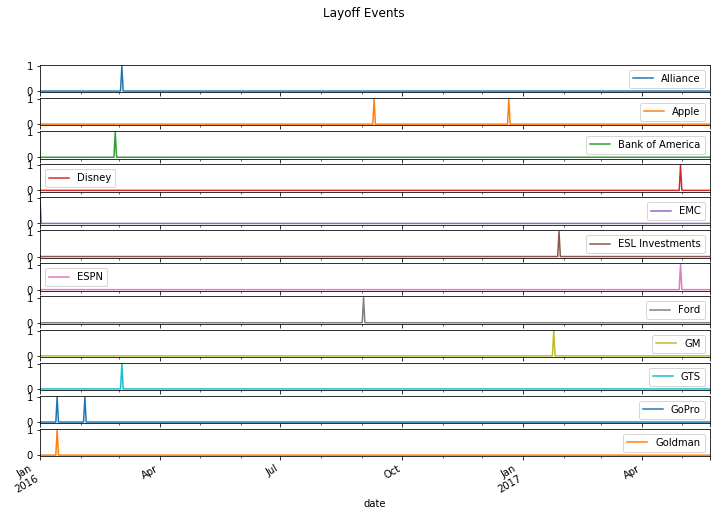

In [1245]:
dfef.assign(ind=1).pivot_table(index='date', columns='org', values='ind')\
    .sort_index().fillna(0).resample('1D').max().fillna(0)\
    .iloc[:,:12]\
    .plot(figsize=(12, 8), legend=True, subplots=True, title='Layoff Events')
None

In [1168]:
dfef.assign(org_lower=lambda df: df['org'].str.lower())['org_lower'].nunique()

42

In [1169]:
dfef['org'].nunique()

42

Split into time period before and after layoff events:

In [1170]:
event_dates = dfef.assign(org_lower=lambda df: df['org'].str.lower())\
    .groupby(['org', 'org_lower'])['date'].min().rename('umi').reset_index()
event_dates['ulo'] = event_dates['umi'] - pd.DateOffset(months=1)
event_dates['uhi'] = event_dates['umi'] + pd.DateOffset(months=1)
event_dates['lmi'] = event_dates['umi'] - pd.DateOffset(months=3)
event_dates['llo'] = event_dates['lmi'] - pd.DateOffset(months=6)
event_dates['lhi'] = event_dates['lmi'] + pd.DateOffset(months=1)
print(len(event_dates))
event_dates.head()

42


,org,org_lower,umi,ulo,uhi,lmi,llo,lhi
0,Alliance,alliance,2016-03-03,2016-02-03,2016-04-03,2015-12-03,2015-06-03,2016-01-03
1,Apple,apple,2016-09-10,2016-08-10,2016-10-10,2016-06-10,2015-12-10,2016-07-10
2,Bank of America,bank of america,2016-02-27,2016-01-27,2016-03-27,2015-11-27,2015-05-27,2015-12-27
3,Disney,disney,2017-04-30,2017-03-30,2017-05-30,2017-01-30,2016-07-30,2017-02-28
4,EMC,emc,2016-01-01,2015-12-01,2016-02-01,2015-10-01,2015-04-01,2015-11-01


Classify sentences as either before or near layoff events:

In [151]:
def get_matches(sent):
    matches = matcher(sent)
    res = {}
    for match_id, start, end in matches:
        string_id = nlp.vocab.strings[match_id]
        span = sent[start:end] 
        for ent in span.ents:
            if ent.label_ == 'ORG':
                res[span] = ent
    return [(v, k) for k, v in res.items()]

def extract(df):
    res = []
    df = df[df['content'].notnull() | df['title'].notnull()]
    dtm = event_dates.set_index('org_lower').to_dict(orient='index')
    for i, r in tqdm.tqdm_notebook(df.iterrows(), total=len(df)):
        to_str = lambda t: clean(t) + '. ' if not pd.isnull(t) else ''
        text = to_str(r['title']) + to_str(r['content'])
        doc = nlp(text)
        
        cands = []
        for sent in doc.sents:
            for ent in sent.ents:
                if ent.label_ == 'ORG':
                    cands.append((ent, sent))
                    
        for c in cands:
            org = c[0].lower_
            if org not in dtm:
                continue
            period = None
            if dtm[org]['llo'] <= r['date'] <= dtm[org]['lhi']:
                period = 'preceding'
            if dtm[org]['ulo'] <= r['date'] <= dtm[org]['uhi']:
                period = 'current'
            if period is None:
                continue
            rec = {'org': dtm[org]['org'], 'org_lower': org, 'period': period, 'sent': str(c[1])}
            res.append({**r[['id', 'date', 'year', 'month', 'publication', 'category']].to_dict(), **rec})
    return pd.DataFrame(res)

dfctxt = extract(df)

In [371]:
dft = dfctxt.copy().assign(sent = lambda df: df['sent'].apply(str).str.lower())
dft[dft['sent'].str.lower().str.contains('shrinking.{1,50}market')]

,category,date,id,month,org,org_lower,period,publication,sent,year
545,business,2016-01-04,67538,1,Intel,intel,preceding,Business Insider,"but with a shrinking pc market, intel has been exploring new ways to grow its business, making headway into other areas like chips for data centers and connected devices.",2016
951,business,2016-02-26,68378,2,HP,hp,current,Business Insider,"along with this restructuring, investors also grew nervous about the potential for growth in the shrinkingxa0printer and pc markets that hp plays in.",2016


In [155]:
dfctxt.groupby(['org', 'period']).size().rename('count').unstack().sort_values('preceding', ascending=False)

period,current,preceding
org,,
Apple,256.0,791.0
Google,148.0,466.0
Microsoft,72.0,115.0
Ford,47.0,46.0
ESPN,48.0,41.0
Disney,15.0,30.0
Sears,115.0,30.0
GM,21.0,22.0
Nissan,13.0,16.0


### Add Random Entries

Pad the dataset with near-layoff articles using articles from other companies, which may have any sentiment:

In [438]:
def get_all_mentions(df):
    res = []
    for i, r in tqdm.tqdm_notebook(df.iterrows(), total=len(df)):
        doc = nlp(get_text(r))
        for sent in doc.sents:
            for ent in sent.ents:
                if ent.label_ == 'ORG':
                    rec = {'org': ent.text, 'org_lower': ent.lower_, 'period': 'random', 'sent': str(sent)}
                    res.append({**r[['id', 'date', 'year', 'month', 'publication', 'category']].to_dict(), **rec})
    return pd.DataFrame(res)

dfext = get_all_mentions(df[~df['id'].isin(dfctxt['id'].unique())])
print(len(dfext))
dfext.head()

70651


,category,date,id,month,org,org_lower,period,publication,sent,year
0,business,2016-12-31,64824,12,Trump,trump,random,Business Insider,"(Trump, focuses, New, Year, 's, tweet, on, ', many, enemies, ', and, everyone, who, ', lost, so,...",2016
1,business,2016-12-31,64824,12,Trump,trump,random,Business Insider,"( , In, his, New, Year, 's, address, on, Saturday, ,, , that, the, two, countries, will, "", tak...",2016
2,business,2016-12-31,64824,12,EVERYONE,everyone,random,Business Insider,"(Love!tt, tttTo, EVERYONE, ,, including, all, haters, and, losers, ,, HAPPY, NEW, YEAR, .)",2016
3,business,2016-12-31,64824,12,NYE,nye,random,Business Insider,"(WE, MUST, ALL, WORK, TOGETHER, TO, ,, FINALLY, ,, MAKE, AMERICA, SAFE, AGAIN, AND, GREAT, AGAIN...",2016
4,business,2016-12-31,64826,12,Washington Post,washington post,random,Business Insider,"(Russian, hackers, breached, a, Vermont, electrical, utility, ,, The, , Washington, Post, , on...",2016


In [440]:
dfext['org'].nunique()

14413

In [1106]:
# Sample organizations and pick out companies
dfext['org'].value_counts().sort_values().tail(1000).sample(30)

Justice Department                    44
SDN                                    8
KGB                                   32
Castile                               12
Defense                               46
AQAP                                   8
Reuters/Ipsos                         11
Justice                               35
Kraft Heinz                            8
Marine                                21
WACC                                  10
Columbia                              50
Deutsche Bank                         55
the House  Intelligence Committee     10
ECB                                   12
Recode                                 9
the Clinton Foundation                13
Fox                                  107
The Huffington Post                    7
Citadel                               10
Packers                               17
EPA                                   66
Bank of America                       22
Montgomery                             8
LinkedIn        

In [1107]:
dfrand = dfext[dfext['org'].isin([
    'Watson Health', 'Nike', 'Tesla', 'Jeep', 
    'Vineyard Vines', 'AT&T', 'Salesforce',
    'Lamborghini', 'Waymo', 'LinkedIn', 'Pepsi'
])]
dfrand.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1148 entries, 47 to 70605
Data columns (total 10 columns):
category       1148 non-null object
date           1148 non-null datetime64[ns]
id             1148 non-null int64
month          1148 non-null int64
org            1148 non-null object
org_lower      1148 non-null object
period         1148 non-null object
publication    1148 non-null object
sent           1148 non-null object
year           1148 non-null int64
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 98.7+ KB


In [1201]:
dfmdl = pd.concat([dfctxt, dfrand])
dfmdl['sent'] = dfmdl['sent'].astype(str).str.replace('xa0', ' ') # Replace this common encoding error
dfmdl['sent'] = dfmdl['sent'].apply(lambda v: re.sub(r'[^\w.]+$', '', v)) # Remove trailing punctuation
dfmdl = dfmdl.drop_duplicates(['org', 'sent'])
dfmdl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2782 entries, 0 to 70208
Data columns (total 10 columns):
category       2782 non-null object
date           2782 non-null datetime64[ns]
id             2782 non-null int64
month          2782 non-null int64
org            2782 non-null object
org_lower      2782 non-null object
period         2782 non-null object
publication    2782 non-null object
sent           2782 non-null object
year           2782 non-null int64
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 239.1+ KB


In [1360]:
dfmdl['org_lower'].nunique()

53

In [1361]:
dfmdl['sent'].astype(str).nunique()

2668

In [1375]:
print('\n'.join(dfmdl['sent'].astype(str).sample(n=10).str[:250].values))

In the last four years, coffee has gone  from a $7 billion annual industry (for the 52 weeks ending June  2, 2012) to a $9 billion business (for the 52 weeks ending May  28, 2016), according to Nielsen data Meanwhile, soda sales in the US per capita 
Jawbone, the richly valued maker of wearable gadgets and wireless  speakers, appears to be on increasingly shaky financial  footing as it struggles to pay vendors and keep inventory in  stock Jawbone abruptly ended its relationship with  the customer
All 39  letters paint a similar picture of the person Turner was in high  school and college before he was convicted of three counts of  felony sexual assault Close friends, family members, former coaches, and teammates  supplied the letters to Judge
The layoffs come as Sears looks for ways to cut costs as its debt load balloons and sales continue to decline Same-store sales at Sears and Kmart stores fell by more than 12% during the all-important holiday season Sears CEO Eddie Lampert recently

### Generate Pairs

Create pairs of sentences and templates to compare them to:

In [1342]:
def get_pairs(template):
    def prep_pair(org, sentence):
        return str(sentence).replace(org, 'the company'), template.replace('::Company::', 'the company')

    def prep_sentence_from_ctxt(r):
        sent, title = prep_pair(r['org'], str(r['sent']))
        return {**r.to_dict(), **{'sent_prep': sent, 'title_prep': title}}

    dfpair = pd.DataFrame([prep_sentence_from_ctxt(r) for _, r in dfmdl.iterrows()])
    return dfpair

In [1343]:
TEMPLATES = [
    'Investors have grown nervous about shrinking markets for ::Company::.', 
    '::Company:: CEO steps down after controversy.', 
    '::Company:: is laying off many employees.', 
    '::Company:: shares have collapsed and sales are down.',
    'The product will require ::Company:: to coordinate with the government and apply for permits',
    '::Company:: is working on several risky moonshot projects'
]
mpair = {
    tmpl: get_pairs(tmpl)
    for tmpl in TEMPLATES
}

In [1344]:
dfpair = mpair[TEMPLATES[0]]
pd.set_option('display.max_colwidth', 100)
dfpair.sample(n=3)

,category,date,id,month,org,org_lower,period,publication,sent,sent_prep,title_prep,year
734,business,2016-02-26,68376,2,Apple,apple,preceding,Business Insider,Apple is using 2 main arguments in its epic fight against the FB.,the company is using 2 main arguments in its epic fight against the FB.,Investors have grown nervous about shrinking markets for the company.,2016
2235,business,2017-04-02,66251,4,Tesla,tesla,random,Business Insider,"And the company hasn't slowed down in 2017. "", 'So far this year the company has changed its nam...","And the company hasn't slowed down in 2017. "", 'So far this year the company has changed its nam...",Investors have grown nervous about shrinking markets for the company.,2017
78,business,2017-01-09,64951,1,Sears,sears,current,Business Insider,"About a year after the deal to create Sears Holdings closed, Lampert described the company — w...","About a year after the deal to create the company Holdings closed, Lampert described the compa...",Investors have grown nervous about shrinking markets for the company.,2017


In [1345]:
dfpair['sent_prep'].iloc[0]

"the company and the company Home promote fake news story about Obama 'shocking the country' by running for a third ter."

In [1346]:
dfpair['sent_prep'].nunique()

2782

In [1347]:
dfpair['org'].nunique()

53

### Analyze BERT Sentence Embeddings

In [1221]:
bc.close()

In [1222]:
from bert_serving.client import BertClient
bc = BertClient(ip='10.0.1.127', check_length=False)
tmp=bc.encode(['First do it', 'then do it right', 'then do it better'])
tmp.shape

(3, 768)

In [1223]:
from sklearn.metrics.pairwise import cosine_similarity

def get_predictions(sentences):
    sentences = [str(s) for s in sentences]
    res = bc.encode(sentences)
    assert res.shape[0] == len(sentences)
    return [list(r) for r in res]

def get_similarity(v1, v2):
    v1 = np.asarray(v1)[np.newaxis,:]
    v2 = np.asarray(v2)[np.newaxis,:]
    res = cosine_similarity(v1, v2)
    assert res.size == 1
    return res[0][0]

dfencode = pd.concat([
    (
        df
        .assign(template=tmpl)
        .assign(sent_embedding=lambda df: get_predictions(df['sent_prep']))
        .assign(title_embedding=lambda df: get_predictions(df['title_prep']))
        .assign(similarity=lambda df: df.apply(lambda r: get_similarity(r['sent_embedding'], r['title_embedding']), axis=1))
    )
    for tmpl, df in tqdm.tqdm(mpair.items())
])








  0%|          | 0/6 [00:00<?, ?it/s]






 17%|█▋        | 1/6 [00:18<01:34, 18.90s/it]






 33%|███▎      | 2/6 [00:30<01:06, 16.69s/it]






 50%|█████     | 3/6 [00:50<00:52, 17.62s/it]






 67%|██████▋   | 4/6 [01:10<00:36, 18.47s/it]






 83%|████████▎ | 5/6 [01:22<00:16, 16.48s/it]






100%|██████████| 6/6 [01:38<00:00, 16.36s/it]

In [1224]:
dfencode['similarity'].describe()

count    16692.000000
mean         0.594221
std          0.052338
min          0.419519
25%          0.557471
50%          0.591798
75%          0.629216
max          0.837524
Name: similarity, dtype: float64

In [880]:
#dfmdl[(dfmdl['org'] == "Nissan") & (dfmdl['sent'].apply(str).str.contains('CEO'))]

In [1234]:
pd.set_option('display.max_colwidth', 600)
templates = dfencode['template'].unique()
dfencode[dfencode['template'] == templates[0]].sort_values('similarity', ascending=False)\
    .head(15)\
    .filter(items=['category', 'date', 'id', 'org', 'period', 'sent', 'title_prep', 'similarity'])

,category,date,id,org,period,sent,title_prep,similarity
743,business,2016-02-26,68378,HP,current,"Along with this restructuring, investors also grew nervous about the potential for growth in the shrinking printer and PC markets that HP plays in.",Investors have grown nervous about shrinking markets for the company.,0.837524
1068,business,2016-05-03,69423,Apple,preceding,"Aside from slowing iPhone sales, Apple investors are most worried about the company's relationship with China, which seems to have .",Investors have grown nervous about shrinking markets for the company.,0.783929
2356,business,2016-01-23,67842,Salesforce,random,And that puts strong and growing tech companies like Salesforce in a position to go shopping as stock prices and private valuations decline.,Investors have grown nervous about shrinking markets for the company.,0.776232
2596,business,2016-08-31,71325,Salesforce,random,"Salesforce has spent over $4 billion on acquisitions in the past year alone, and it's making some investors grow concerned about the company's spending strategy.",Investors have grown nervous about shrinking markets for the company.,0.772231
2595,business,2016-08-31,71325,Salesforce,random,"Investors are worried about Salesforce's $4 billion buying binge, and are looking for answer.",Investors have grown nervous about shrinking markets for the company.,0.770620
415,business,2016-01-01,67480,Apple,preceding,"Declines this year have wiped out about $57 billion in Apple's market capitalization, about as much as fellow Dow component DuPont Co is worth.",Investors have grown nervous about shrinking markets for the company.,0.763536
1358,business,2016-06-17,70139,Apple,preceding,"Unfortunately for Best Buy, analysts see Apple's sales growth being challenged in the coming quarters.",Investors have grown nervous about shrinking markets for the company.,0.754262
2765,business,2016-12-18,73051,Tesla,random,"In that respect, Tesla has disappointed investors.",Investors have grown nervous about shrinking markets for the company.,0.753093
531,business,2016-01-20,67791,Macy,current,Macy's Backstage stores is an attempt to get younger customers as sales at its core business decline.,Investors have grown nervous about shrinking markets for the company.,0.749282
2733,business,2016-12-01,72779,Salesforce,random,Wood believes the growing market share across most of Salesforce's products is one reason for that.,Investors have grown nervous about shrinking markets for the company.,0.746975


In [1191]:
def compare(sent, docs):
    doc_vecs = bc.encode(docs)
    sent_vec = bc.encode([sent])
    #score = np.sum(sent_vec * doc_vecs, axis=1) / np.linalg.norm(doc_vecs, axis=1)
    scores = cosine_similarity(sent_vec, doc_vecs).squeeze()
    return scores

scores = compare(
    'the company shares have collapsed and earnings have decreased.', 
    [
    'People who bought shares on August 19, 2004, and kept it have made off well, as the stock price of the company and parent company Alphabet has skyrocketed.\', "',
    'People who bought shares on August 19, 2004, and kept it have made off well, as the stock price of the company and parent company Alphabet has skyrocketed.'
    ]
)
scores

array([0.8054017, 0.8091144], dtype=float32)

In [1279]:
dfencode\
    .pipe(lambda df: df[df['sent'].str.len() >= 12])\
    .pipe(lambda df: df[df['sent'] != 'owns shares of Apple.'])\
    .groupby('template', group_keys=False)\
    .apply(lambda g: g.assign(rank=g['similarity'].rank(method='first', ascending=False)))\
    .pipe(lambda df: df[df['rank'] <= 6])\
    .pivot(index='rank', columns='template', values='sent')

template,::Company:: CEO steps down after controversy.,::Company:: is laying off many employees.,::Company:: is working on several risky moonshot projects,::Company:: shares have collapsed and sales are down.,Investors have grown nervous about shrinking markets for ::Company::.,The product will require ::Company:: to coordinate with the government and apply for permits
rank,,,,,,
1.0,Ford CEO responds to Trump’s criticism of the compan. .,Apple laid off dozens of employees working on its self-driving ca.,"Alphabet, the parent company of Google, has pioneered the ambitious ""moonshot"" projects to reinvent everything from cars to healthcare.","Sears is struggling Sales have been , and the company is selling off real estate and closing stores to stay afloat.","Along with this restructuring, investors also grew nervous about the potential for growth in the shrinking printer and PC markets that HP plays in.","Google X also employs ""experts"" to help teams mitigate challenging work environments, and the Project Wing team made changes to the test site after spending time with one such adviser If an employee has a medical issue, Google follows the guidance and restrictions of the medical provider and engages with the employee to determine if a ""reasonable accommodation"" is necessary, she said."
2.0,Nissan's CEO Carlos Ghosn just stepped dow.,Sears is laying off workers to stay in busines.,"While Apple has never publically acknowledged that it's working on a vehicle, first reported in early 2015 that it had several hundred employees working on an Apple-branded electric car.",Apple shares were further hurt by news on April 28 from billionaire investor in the company.,"Aside from slowing iPhone sales, Apple investors are most worried about the company's relationship with China, which seems to have .","The Commission said it would decide at a later stage whether to let Google charge competitors for displaying their services prominently, with the amount corresponding to Google's operating cost or a nominal amount based on the lowest reserve price for AdWords which is currently 0.01 euro per click.."
3.0,There was a time when Yahoo CEO Marissa Mayer was considered Yahoo's savior.,"Most employees out of Pebble's staff of about 100 were laid off, their stock suddenly worthless.","Musk is juggling quite a few projects on top of the Boring Company, including Tesla's upcoming Model 3 launch and the rollout of a solar roof product.","People who bought shares on August 19, 2004, and kept it have made off well, as the stock price of Google and parent company Alphabet has skyrocketed.",And that puts strong and growing tech companies like Salesforce in a position to go shopping as stock prices and private valuations decline.,"If Apple would prefer that course, however, that may provide an alternative that requires less labor by Apple."
4.0,"In that respect, Tesla has disappointed investors.","The move affected 93 jobs at NexRep, with many staffers being laid off.","I learned a lot from working at ESPN, which was an amazing company with amazing people.",Sears is shutting down stores to help stem losses from falling sales.,"Salesforce has spent over $4 billion on acquisitions in the past year alone, and it's making some investors grow concerned about the company's spending strategy.","Technology and security experts said that if the U.S. government was able to obtain Apple's source code with a conventional court order, other governments would demand equal rights to do the same thing."
5.0,"Nearly two decades after saving Nissan from the brink of financial collapse, CEO Carlos Ghosn is taking on another Japanese reclamation project.","During the interviews, Fitbit quizzed Pebble employees on their roles at the company, but in the end Pebble employees learned there was no interest in the hardware team.",The idea that anyone at Tesla is working on a big freight vehicle is flatly inexplicable.,Coke and Pepsi are relying on an unexpected group to boost 

### Analyze USE Sentence Embeddings

In [1348]:
import requests
from sklearn.metrics.pairwise import cosine_similarity

def encode(sentences):
    sentences = [str(s) for s in sentences]
    res = requests.post('http://10.0.1.127:5000/use_embed', json={"sentences": sentences})
    if not res.ok:
        raise ValueError(res)
    res = np.array(res.json())
    assert res.shape[0] == len(sentences)
    return [list(r) for r in res]

def get_similarity(v1, v2):
    v1 = np.asarray(v1)[np.newaxis,:]
    v2 = np.asarray(v2)[np.newaxis,:]
    res = cosine_similarity(v1, v2)
    assert res.size == 1
    return res[0][0]

dfencode = pd.concat([
    (
        df
        .assign(template=tmpl)
        .assign(sent_embedding=lambda df: encode(df['sent_prep']))
        .assign(title_embedding=lambda df: encode(df['title_prep']))
        .assign(similarity=lambda df: df.apply(lambda r: get_similarity(r['sent_embedding'], r['title_embedding']), axis=1))
    )
    for tmpl, df in tqdm.tqdm_notebook(mpair.items())
])

In [1354]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1356]:
dfencode\
    .pipe(lambda df: df[df['sent'].str.len() >= 12])\
    .pipe(lambda df: df[df['sent'] != 'owns shares of Apple.'])\
    .groupby('template', group_keys=False)\
    .apply(lambda g: g.assign(rank=g['similarity'].rank(method='first', ascending=False)))\
    .pipe(lambda df: df[df['rank'] <= 16])\
    .pivot(index='rank', columns='template', values='sent')

template,::Company:: CEO steps down after controversy.,::Company:: is laying off many employees.,::Company:: is working on several risky moonshot projects,::Company:: shares have collapsed and sales are down.,Investors have grown nervous about shrinking markets for ::Company::.,The product will require ::Company:: to coordinate with the government and apply for permits
rank,,,,,,
1.0,"IBM's restructuring continues, with reduced severance for laid off employee.",Sears is laying off workers to stay in busines.,Musk has been forthcoming about Tesla's production challenges in the first half of 2016.,LinkedIn is crashing after weak earnings guidanc.,"Analysts are looking for revenue guidance of $55.7 billion, which would be a 4% drop — the first revenue decline in Apple's modern history.","Apple would have to test its car on public roads — in fact, it would have to let various governments know that it was doing so, and if it wants to shoot for self-driving features, it will be required to apply for permits in California."
2.0,Intel CEO Brian Krzanich says he's received threats for trying to hire more minoritie.,"HP will lay off 3,000 workers this yea.","Musk is juggling quite a few projects on top of the Boring Company, including Tesla's upcoming Model 3 launch and the rollout of a solar roof product.","Sears is struggling Sales have been , and the company is selling off real estate and closing stores to stay afloat.","Salesforce has spent over $4 billion on acquisitions in the past year alone, and it's making some investors grow concerned about the company's spending strategy.","But it will feed into Tesla's other products — and provide Tesla with a way to free SolarCity from its current leasing model, moving toward selling solar solutions rather than loaning them out."
3.0,Apple is losing the battle of public opinion....,Intel is reportedly going to cut thousands of job.,"The Powerpacks are manufactured at Tesla's massive Gigafactory in Sparks, Nevada.","Sales are down 37% since early 2013, Sears' debt load has spiked to over $1.6 billion, and the company is losing well over $1 billion annually.","IPO chances: Likely', ""HotelTonight reversed its course in 2016, laying off 20% of its staff after burning millions a month.","The products offered by Quidsi will be stocked on Amazon.com, and Quidsi's programmers will work on the AmazonFresh grocery service."
4.0,Nissan's CEO Carlos Ghosn just stepped dow.,LinkedIn is crashing after weak earnings guidanc.,"Musk has managed to rev up enthusiasm for Tesla's solar roof, and an early rollout of that product would start to shift the old SolarCity business away from leasing and toward fully purchased solar solutions.",Google's investment arm has quietly invested in Snapcha.,Bank of America is preparing big layoffs in investment banking and tradin.,"If the SolarCity deal goes through, then Tesla will be a carmaker; a battery maker, thanks to the Gigafactory being built in Nevada; an energy storage company, thanks to Tesla Energy, unveiled last year and selling residential battery packs; and a solar finance firm Put all that together under one roof and you get a company that can sell or lease you a zero-emission, off-the-grid lifestyle."
5.0,Multiple messages left for NexRep's CEO went unreturned.,"US Steel, for example, said on Wednesday laying off 25% of its nonunion workforce.","Google employees explored partial autonomy, along the lines of Tesla Autopilot, in 2012.","And until the tail end of 2016, Tesla was enduring a slow stock slide.","Investors are worried about Salesforce's $4 billion buying binge, and are looking for answer.","But that oversimplifies the problem, because Tesla will obviously have to participate in managing Gigafactory production."
6.0,Intel CEO Brian Krzanich said something startling toward the end of the company's earnings call on Tuesday.,Bank of America is preparing big layoffs in investment banking and tradin.,"Musk said during that same question-and-answers ses